Import de toutes les bibliothèques concernés

!pip install wordcloud==1.9.3

In [437]:
!pip install ipywidgets==8.1.2

In [438]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [439]:
# Charger les données d'entraînement et de test
airbnb_train = pd.read_csv('airbnb_train.csv')
airbnb_test = pd.read_csv('airbnb_test.csv')

# Afficher les premières lignes pour comprendre la structure des données
airbnb_train.head()
print(len(airbnb_test))

51877


In [440]:
numeric_features = airbnb_train.select_dtypes(include=['int64','float64']).columns
numeric_features=numeric_features.delete(0)
airbnb_test.head()

Unnamed: 0 property_type        room_type  \
0    14282777     Apartment  Entire home/apt   
1    17029381     Apartment  Entire home/apt   
2     7824740     Apartment  Entire home/apt   
3    19811650         House  Entire home/apt   
4    12410741     Apartment  Entire home/apt   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Air conditioning",Kitche...             3    1.00000   
1  {"Wireless Internet","Air conditioning",Kitche...             7    1.00000   
2  {TV,"Cable TV","Wireless Internet","Air condit...             5    1.00000   
3  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4    1.00000   
4  {TV,Internet,"Wireless Internet","Air conditio...             2    1.00000   

   bed_type cancellation_policy  cleaning_fee city  ... last_review latitude  \
0  Real Bed              strict          True  NYC  ...  2016-07-18 40.69652   
1  Real Bed              strict          True  NYC  ...  2017-09-23 40.76612   
2  Real Bed            moderate          True  NYC  ...  2017-09-14 40.80811   
3  Real Bed            flexible          True   SF  ...         NaN 37.77200   
4  Real Bed            moderate          True   DC  ...  2017-01-22 38.92563   

   longitude                                      name     neighbourhood  \
0  -73.99162            Beautiful brownstone 1-bedroom  Brooklyn Heights   
1  -73.98904  Superb 3BR Apt Located Near Times Square    Hell's Kitchen   
2  -73.94376                          The Garden Oasis            Harlem   
3 -122.43162        Beautiful Flat in the Heart of SF!      Lower Haight   
4  -77.03460                Great studio in midtown DC  Columbia Heights   

  number_of_reviews review_scores_rating  zipcode  bedrooms    beds  
0                 2            100.00000    11201   1.00000 1.00000  
1                 6             93.00000    10019   3.00000 3.00000  
2                10             92.00000    10027   1.00000 3.00000  
3                 0                  NaN  94117.0   2.00000 2.00000  
4                 4             40.00000    20009   0.00000 1.00000  

[5 rows x 27 columns]

Observons les différents types présents dans le data frame

In [441]:
airbnb_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22234 non-null  int64  
 1   log_price               22234 non-null  float64
 2   property_type           22234 non-null  object 
 3   room_type               22234 non-null  object 
 4   amenities               22234 non-null  object 
 5   accommodates            22234 non-null  int64  
 6   bathrooms               22183 non-null  float64
 7   bed_type                22234 non-null  object 
 8   cancellation_policy     22234 non-null  object 
 9   cleaning_fee            22234 non-null  bool   
 10  city                    22234 non-null  object 
 11  description             22234 non-null  object 
 12  first_review            17509 non-null  object 
 13  host_has_profile_pic    22178 non-null  object 
 14  host_identity_verified  22178 non-null

Le data frame train possède bien la colonne log_price en plus

In [442]:
print(airbnb_train.columns)
print(airbnb_test.columns)

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')
Index(['Unnamed: 0', 'property_type', 'room_type', 'amenities', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'description', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude', 'name',
       'neighbourhood', 'number_of_reviews', 'review_scores_rating', 'zipcode',
       'bedrooms', 'beds'],
      dtype='object')


On peut visualiser la qualité du dataframe en observant a quel point il manque des valeurs

In [443]:

missing_values = airbnb_train.isna().sum()
missing_values /= airbnb_train.shape[0]
missing_values *=100
missing_values = missing_values.to_frame().rename(columns={0:'Pourcentage de valeur manquantes'})
missing_values



Pourcentage de valeur manquantes
id                                               0.00000
log_price                                        0.00000
property_type                                    0.00000
room_type                                        0.00000
amenities                                        0.00000
accommodates                                     0.00000
bathrooms                                        0.22938
bed_type                                         0.00000
cancellation_policy                              0.00000
cleaning_fee                                     0.00000
city                                             0.00000
description                                      0.00000
first_review                                    21.25124
host_has_profile_pic                             0.25187
host_identity_verified                           0.25187
host_response_rate                              24.62445
host_since                                       0.25187
instant_bookable                                 0.00000
last_review                                     21.21076
latitude                                         0.00000
longitude                                        0.00000
name                                             0.00000
neighbourhood                                    9.38203
number_of_reviews                                0.00000
review_scores_rating                            22.38913
zipcode                                          1.36278
bedrooms                                         0.11694
beds                                             0.15742

Ilfaut traiter ces valeurs manquantes

In [444]:
airbnb_train = airbnb_train.dropna()

**Visualisons maintenant nos données plus en détails**

On observe une distribution suivant une loi normale des log_prix, le log en est pour quelque chose.

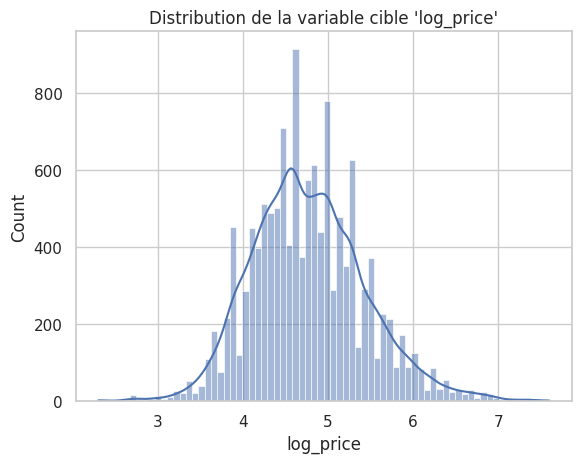

In [445]:
# Distribution de la variable cible 'log_price'
sns.histplot(airbnb_train['log_price'], kde=True)
plt.title("Distribution de la variable cible 'log_price'")
plt.show()


On peut observerver la distribution de toutes les autres valeurs numériques du dataframe

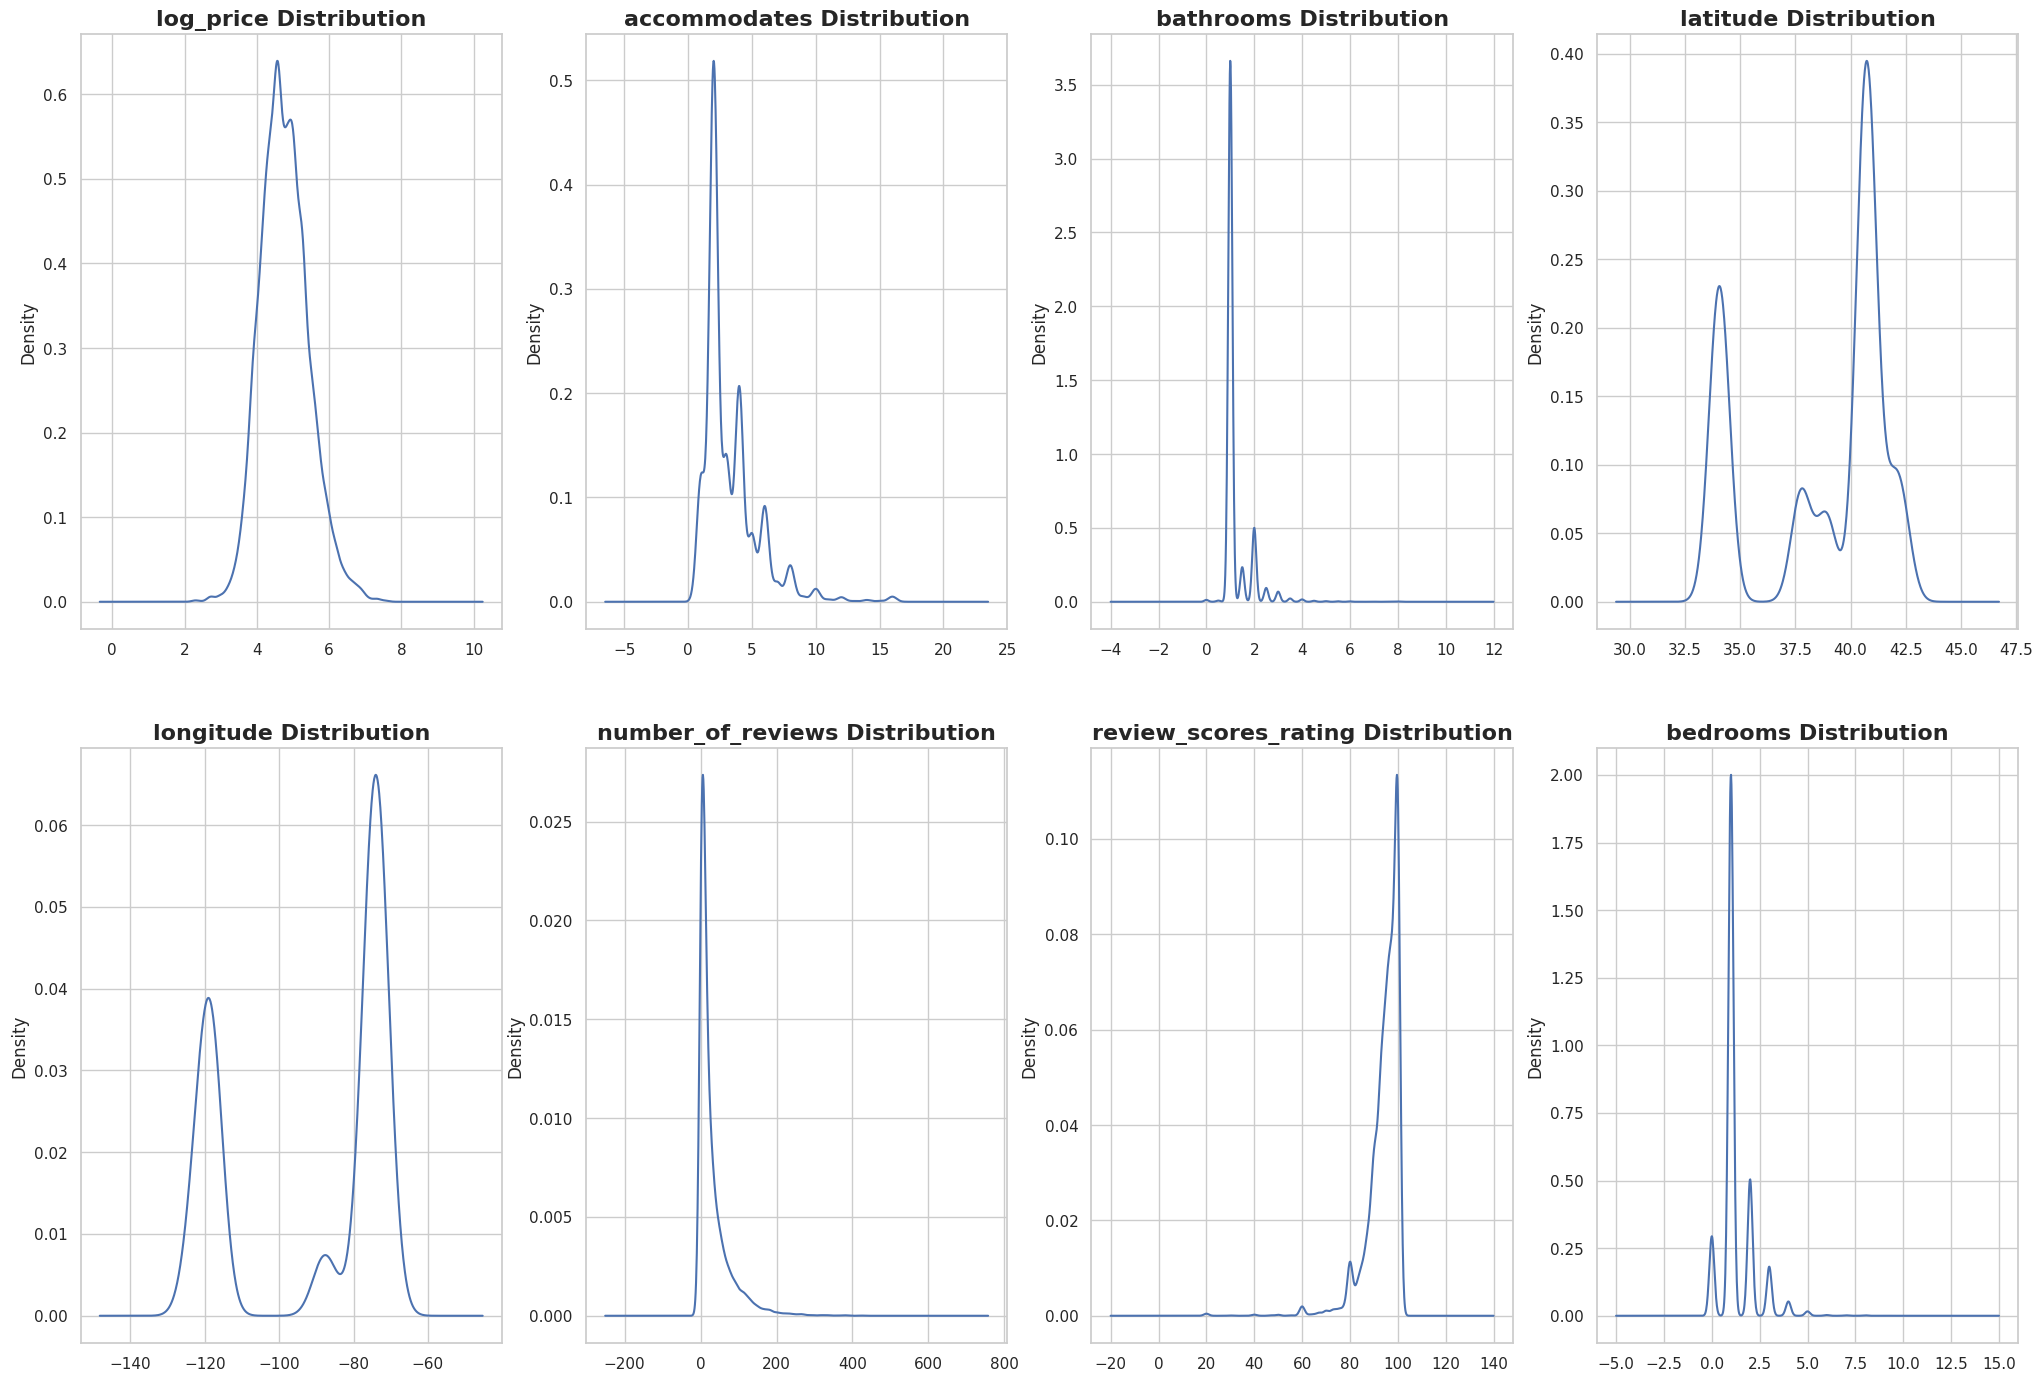

In [446]:
fig, axes = plt.subplots(nrows=2, ncols=4)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        airbnb_train[numeric_features[aux]].plot(kind='kde',ax=col)
        col.set_title(numeric_features[aux] +' Distribution',fontsize=16,fontweight='bold')
        aux+=1

On voit qu'il y a des valeurs abérrantes qui ne nous permettent pas d'afficher correctement nos graphes, avec des conditions, on peut les ignorer ce qui nous données les graphes suivants

In [447]:
lower_bound = .25
upper_bound = .75
iqr = airbnb_train[airbnb_train['log_price'].between(airbnb_train['log_price'].quantile(lower_bound), airbnb_train['log_price'].quantile(upper_bound))]


iqr = iqr[iqr['log_price'] < 8]
iqr = iqr[iqr['accommodates'] > 0]
iqr = iqr[iqr['accommodates'] < 17]
iqr = iqr[iqr['bathrooms'] > 0]
iqr = iqr[iqr['bathrooms'] < 17]
iqr = iqr[iqr['number_of_reviews'] > 0]
iqr = iqr[iqr['number_of_reviews'] < 300]
iqr = iqr[iqr['bedrooms'] > 0]
iqr = iqr[iqr['bedrooms'] < 6]
iqr = iqr[iqr['review_scores_rating'] < 110]

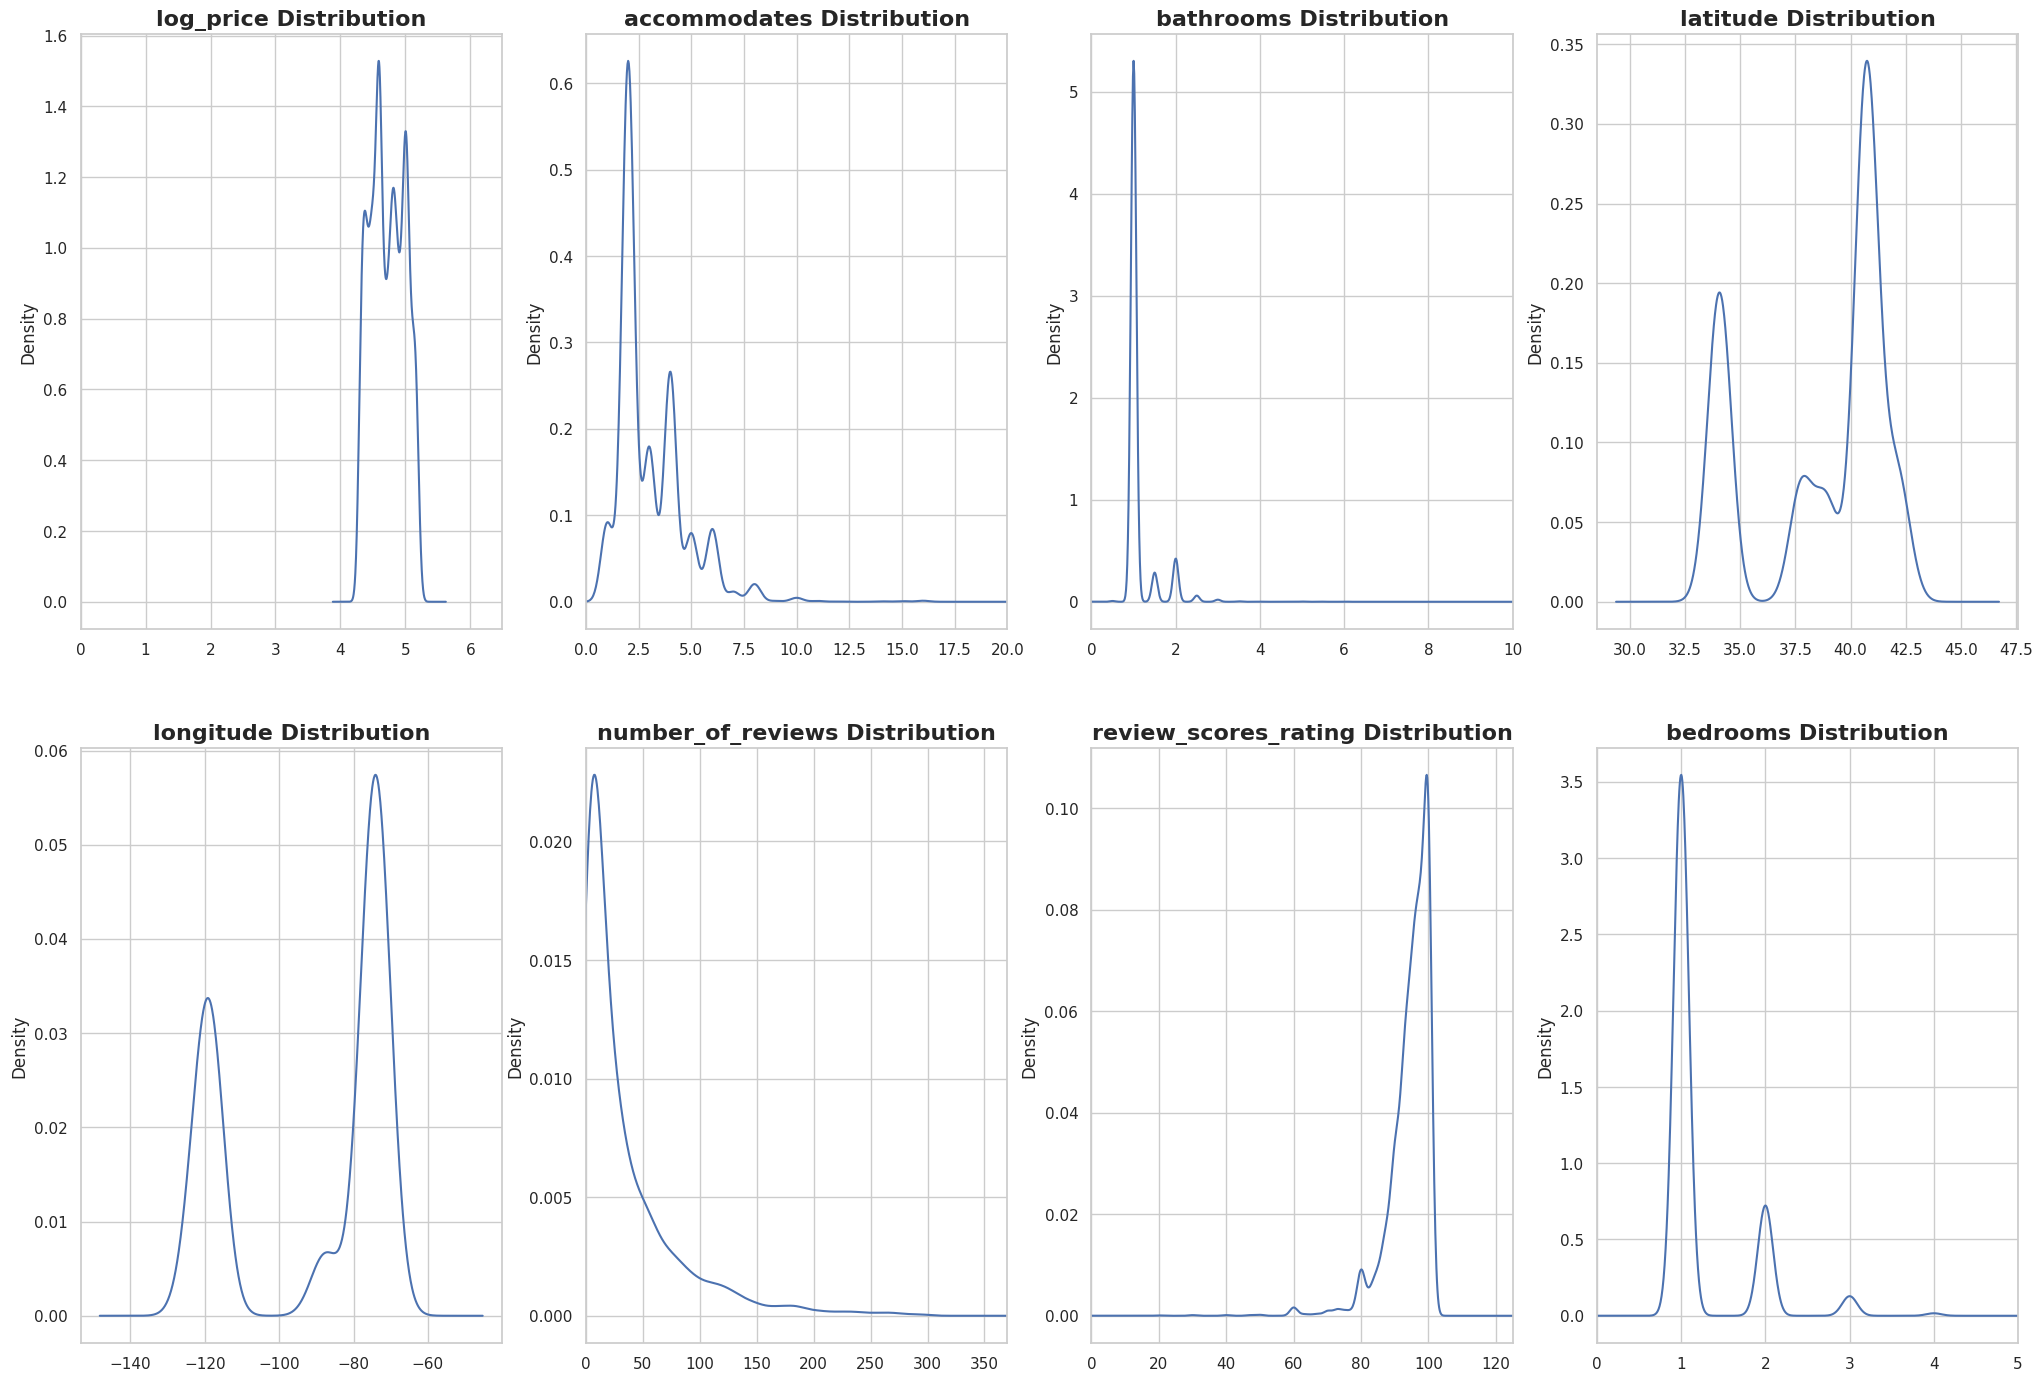

In [448]:
fig, axes = plt.subplots(nrows=2, ncols=4)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        iqr[numeric_features[aux]].plot(kind='kde',ax=col)
        if numeric_features[aux] not in ['latitude','longitude']:
            col.set_xlim(0,iqr[numeric_features[aux]].max()+iqr[numeric_features[aux]].max()*0.25)
        col.set_title(numeric_features[aux] +' Distribution',fontsize=16,fontweight='bold')
        aux+=1

On pourrait prendre le log de certaines valeurs pour obtenir une distribution normale ( comme pour les prix).
On peut déjà penser que toutes ces caratéristiques pour avoir une influence sur le prix, car elle contiennent des infos majeures

Voici d'autres informations autour de ces données numériques

In [449]:
pr_data =iqr.copy()
desc = pr_data.describe()
desc.loc['skew'] = desc.skew()
desc.loc['skew'] = desc.kurt()
pd.set_option('display.float_format', lambda x: '%.5f' % x)

desc.drop(columns='id').style.highlight_max(axis=1)

Une caractéristique particuliere du data frame est aminities, visualisons cela plus en détails, ici on choisit de visualiser les équipements qui reviennent le plus souvent.

1    {"Wireless Internet","Air conditioning",Kitche...
3    {TV,"Cable TV",Internet,"Wireless Internet","A...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
7    {TV,"Cable TV","Wireless Internet","Air condit...
9    {TV,"Cable TV",Internet,"Wireless Internet","A...
Name: amenities, dtype: object


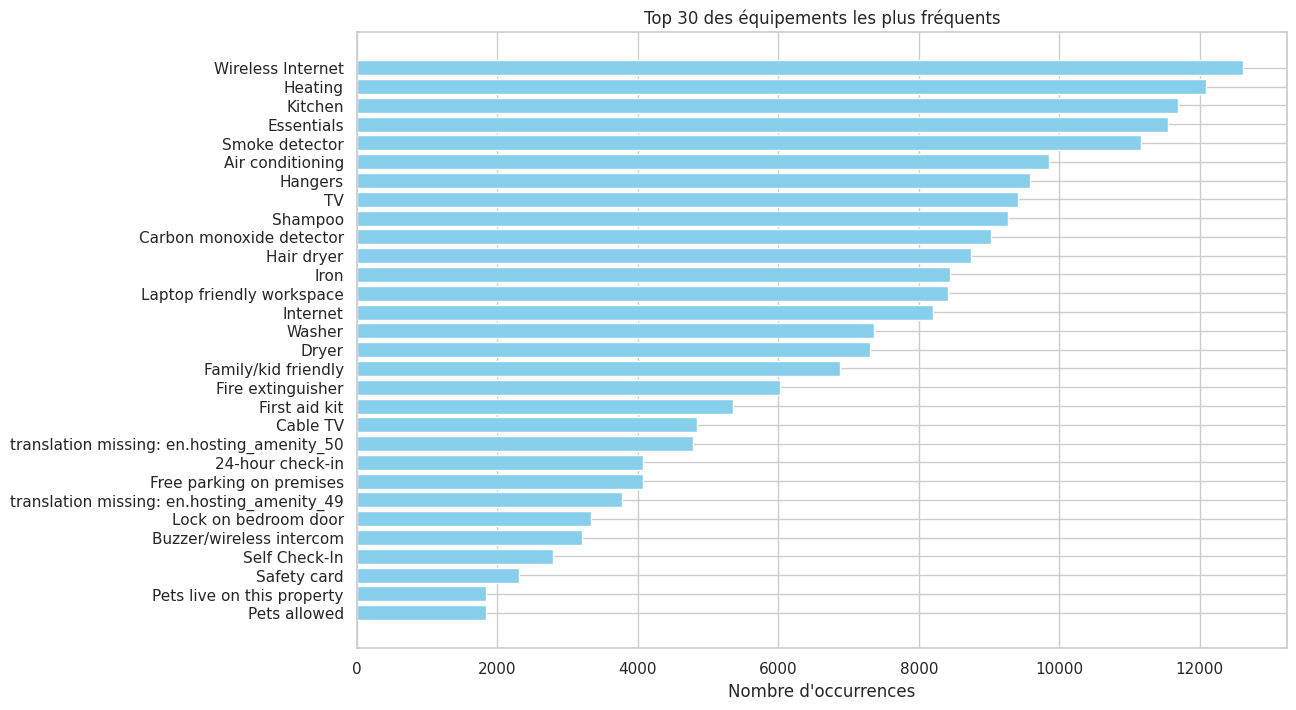

In [450]:
print(airbnb_train['amenities'].head())

# Fonction pour nettoyer et extraire les équipements
def extract_amenities(amenities_str):
    # Enlever les crochets et les guillemets
    amenities_str = amenities_str.strip('{}')
    # Séparer les équipements par virgule
    amenities_list = amenities_str.split(',')
    # Enlever les espaces blancs et les guillemets
    amenities_list = [amenity.strip().strip('"') for amenity in amenities_list]
    return amenities_list

# Extraire les équipements pour chaque entrée
airbnb_train['amenities_list'] = airbnb_train['amenities'].apply(extract_amenities)

# Compter les occurrences de chaque équipement
all_amenities = [amenity for sublist in airbnb_train['amenities_list'] for amenity in sublist]
amenities_count = Counter(all_amenities)

# Afficher les 20 équipements les plus fréquents
top_amenities = amenities_count.most_common(30)
#print(top_amenities)

# Préparer les données pour le graphique
amenities, counts = zip(*top_amenities)

# Créer le graphique à barres
plt.figure(figsize=(12, 8))
plt.barh(amenities, counts, color='skyblue')
plt.xlabel('Nombre d\'occurrences')
plt.title('Top 30 des équipements les plus fréquents')
plt.gca().invert_yaxis()  # Inverser l'axe y pour afficher le plus fréquent en haut
plt.show()

Une autre propriété non numérique interessante à première vue est le type d'habitaton, on visualise la distribution de ceus ci parmis nos data.

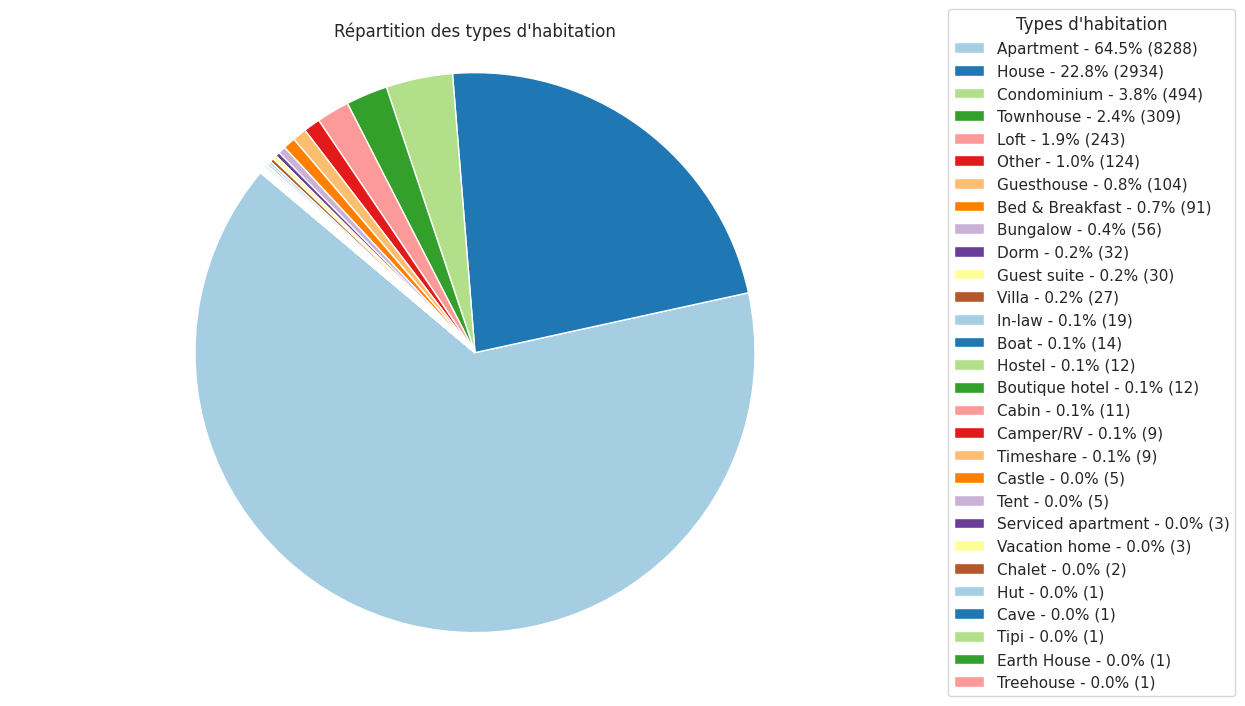

In [451]:
# Compter les occurrences de chaque type d'habitation
property_type_count = airbnb_train['property_type'].value_counts()

# Afficher les types d'habitation les plus fréquents
#print(property_type_count)

# Préparer les données pour le graphique
property_types = property_type_count.index
counts = property_type_count.values

# Calculer les pourcentages
percentages = 100 * counts / counts.sum()

# Créer le diagramme circulaire sans pourcentages
plt.figure(figsize=(12, 8))
wedges, texts = plt.pie(counts, startangle=140, colors=plt.cm.Paired.colors)

# Créer des étiquettes avec les pourcentages et les occurrences
labels = [f'{ptype} - {pct:.1f}% ({cnt})' for ptype, pct, cnt in zip(property_types, percentages, counts)]

# Ajouter la légende avec les pourcentages et les occurrences
plt.legend(wedges, labels, title="Types d'habitation", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Assurer que le cercle soit bien rond
plt.axis('equal')
plt.title("Répartition des types d'habitation")
plt.show()

Aussi de la même la façon, la ville semble jouer un rôle majeur dans le prix, nous affichons la distribution.

<ipython-input-452-ae77b0c2227d>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=airbnb_train['city'],order=airbnb_train['city'].value_counts().index,palette='rocket')
<ipython-input-452-ae77b0c2227d>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=11,fontweight='bold')


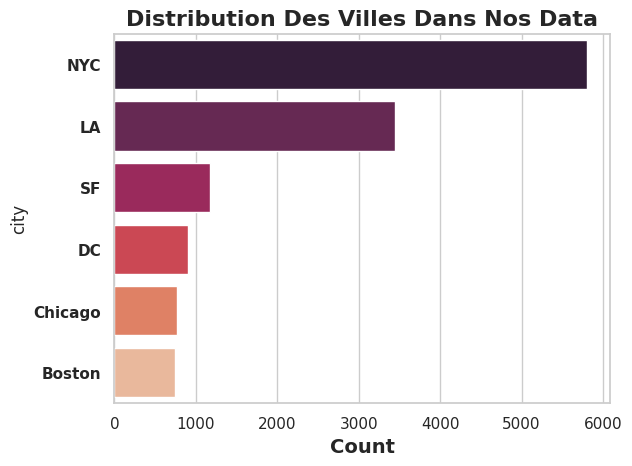

In [452]:
ax = sns.countplot(y=airbnb_train['city'],order=airbnb_train['city'].value_counts().index,palette='rocket')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=11,fontweight='bold')
ax.set_title('Distribution Des Villes Dans Nos Data',fontsize=16,fontweight='bold')
ax.set_xlabel('Count',fontsize=14,fontweight='bold')
#ax.set_title()
plt.show()

Voyons s'il y a une différences notable du prix en fonction de la ville.

      City  Average Price
0   Boston        4.86682
1  Chicago        4.60763
2       DC        4.77962
3       LA        4.74756
4      NYC        4.72350
5       SF        5.12257


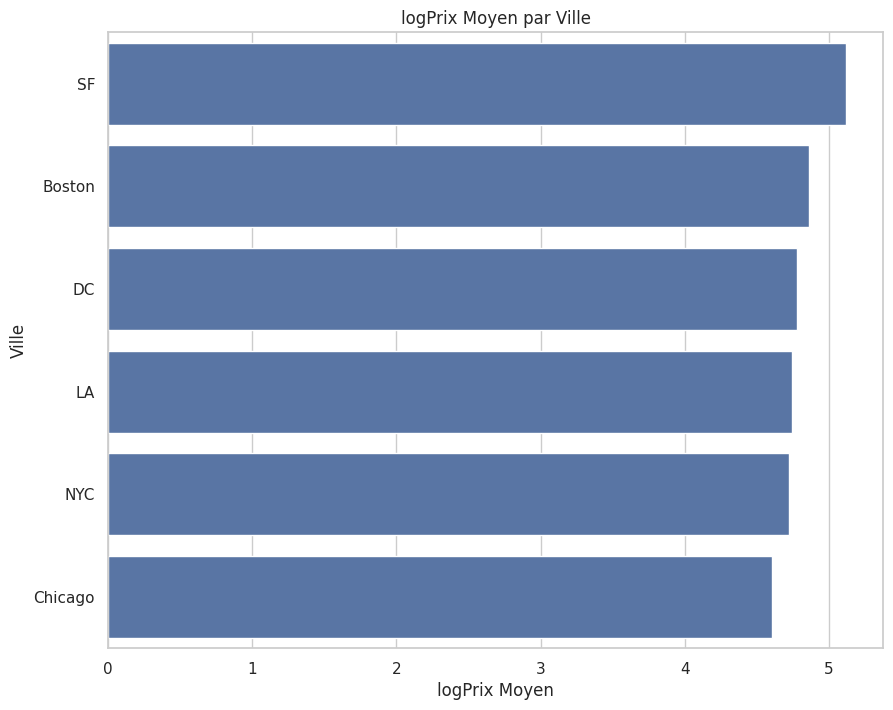

In [453]:
# Calculer le prix moyen par ville
price_means = airbnb_train.groupby('city')['log_price'].mean()

# Préparation d'un DataFrame pour la visualisation
data_for_plot = price_means.reset_index()
data_for_plot.columns = ['City', 'Average Price']  # S'assurer que cette ligne fonctionne correctement

# Vérifiez si les colonnes sont correctement nommées
print(data_for_plot.head(10))

# Trier les données par prix moyen pour une meilleure visualisation
data_for_plot = data_for_plot.sort_values(by='Average Price', ascending=False)

# Création du bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Average Price', y='City', data=data_for_plot)

# Ajouter des titres et des labels
plt.title('logPrix Moyen par Ville')
plt.xlabel('logPrix Moyen')
plt.ylabel('Ville')

# Afficher le graphique
plt.show()


En grande majoritée, des frais de nettoyage semble être appliqués

cleaning_fee
True     10618
False     2223
Name: count, dtype: int64
cleaning_fee
True    82.68826
False   17.31174
Name: proportion, dtype: float64


<ipython-input-454-fde50c27010e>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cleaning_fee', data=airbnb_train, palette='viridis')


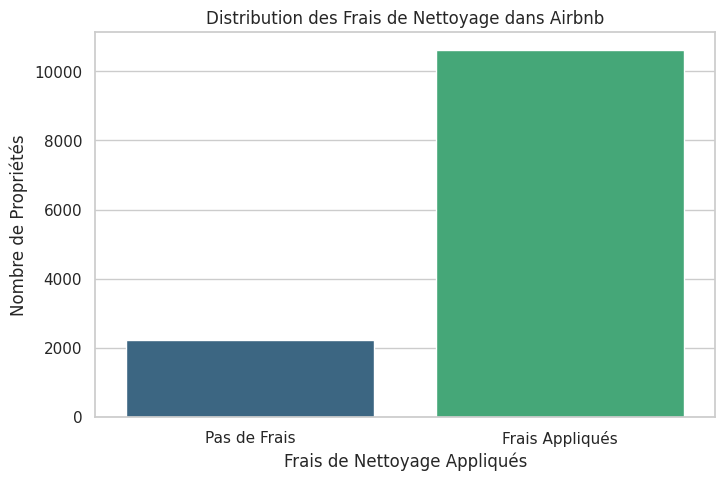

In [454]:
# Calculer la distribution de la colonne `cleaning_fee`
cleaning_fee_distribution = airbnb_train['cleaning_fee'].value_counts()

# Afficher la distribution
print(cleaning_fee_distribution)

# Pour une analyse plus détaillée avec pourcentages:
cleaning_fee_distribution_pct = airbnb_train['cleaning_fee'].value_counts(normalize=True) * 100

# Afficher la distribution en pourcentage
print(cleaning_fee_distribution_pct)
import matplotlib.pyplot as plt
import seaborn as sns

# Configurer le style des graphiques
sns.set(style="whitegrid")

# Créer un diagramme à barres pour la distribution des frais de nettoyage
plt.figure(figsize=(8, 5))
sns.countplot(x='cleaning_fee', data=airbnb_train, palette='viridis')

# Titre et labels
plt.title('Distribution des Frais de Nettoyage dans Airbnb')
plt.xlabel('Frais de Nettoyage Appliqués')
plt.ylabel('Nombre de Propriétés')
plt.xticks([0, 1], ['Pas de Frais', 'Frais Appliqués'])  # Assurer que les labels sont corrects

# Afficher le graphique
plt.show()


Voici un moyen original de visualiser les données textuelles relatives à nos donner, plus le mot est gros plus il apparait souvent dans les datas, respectivement dans les colonnes name et description.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


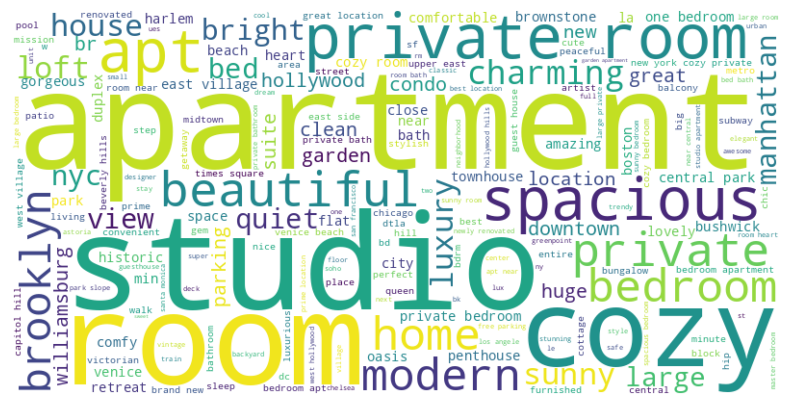

In [455]:

nltk.download('punkt')
nltk.download('stopwords')

# Création d'une fonction pour nettoyer et préparer les données textuelles
def preprocess_text(text):
    text = text.lower()  # convertir en minuscules
    tokens = word_tokenize(text)  # tokenisation
    tokens = [word for word in tokens if word.isalpha()]  # enlever les nombres et la ponctuation
    tokens = [word for word in tokens if not word in stopwords.words('english')]  # enlever les stopwords
    return ' '.join(tokens)

# Appliquer la préparation sur la colonne 'name'
airbnb_train['name'] = airbnb_train['name'].apply(preprocess_text)

# Concaténer tous les textes pour créer un grand texte
text = ' '.join(airbnb_train['name'])

# Créer et afficher le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


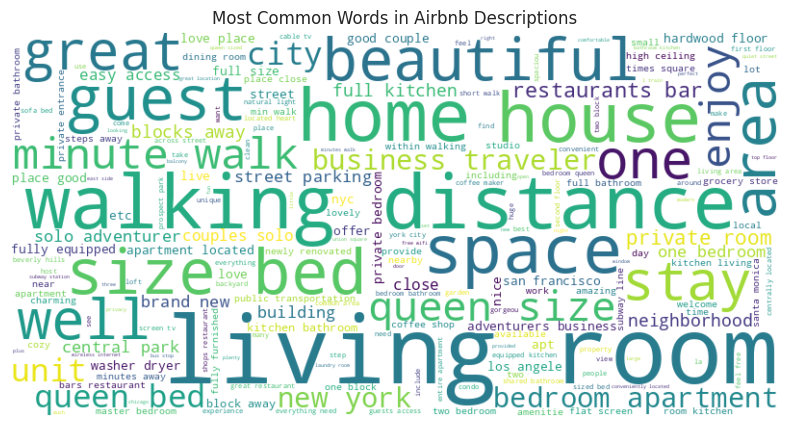

In [456]:
# Appliquer la préparation sur la colonne 'description'
airbnb_train['description_clean'] = airbnb_train['description'].astype(str).apply(preprocess_text)

# Concaténer tous les textes nettoyés pour créer un grand texte
text = ' '.join(airbnb_train['description_clean'])

# Créer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Airbnb Descriptions')
plt.show()


On passe maintenant à l'analyse des données géographiques, on peut naturellement conjecturer que ces données sont très importantes pour determiner un prix.

On peut commencer par simplement plot nos coordonées, avec une palette de couleur en fonction du prix.

<Axes: xlabel='latitude', ylabel='longitude'>

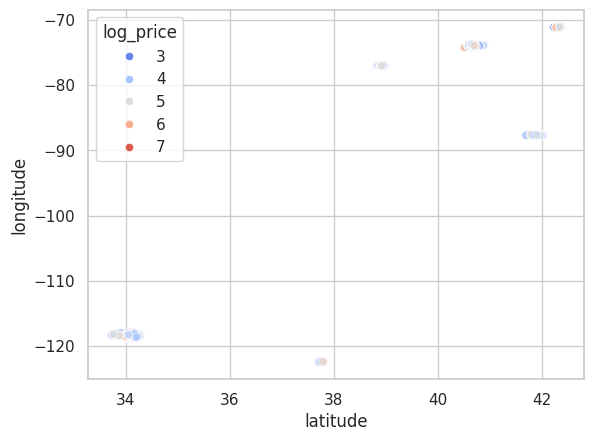

In [457]:
sns.scatterplot(x='latitude',y='longitude',data=airbnb_train,hue='log_price',palette='coolwarm')

On peut voir que les données sont regroupées en quelques endroits precis, avec des conditions, on recadre les plots ce qui permet de voir en détails comment les prix sont répartis dans les villes.

<Axes: xlabel='latitude', ylabel='longitude'>

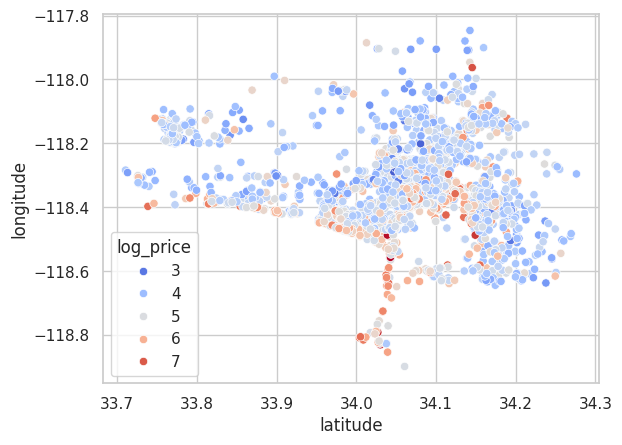

In [458]:
filtered_data = airbnb_train[(airbnb_train['latitude'] < 36) & (airbnb_train['longitude'] < -110)]

sns.scatterplot(x='latitude', y='longitude', data=filtered_data, hue='log_price', palette='coolwarm')


<Axes: xlabel='latitude', ylabel='longitude'>

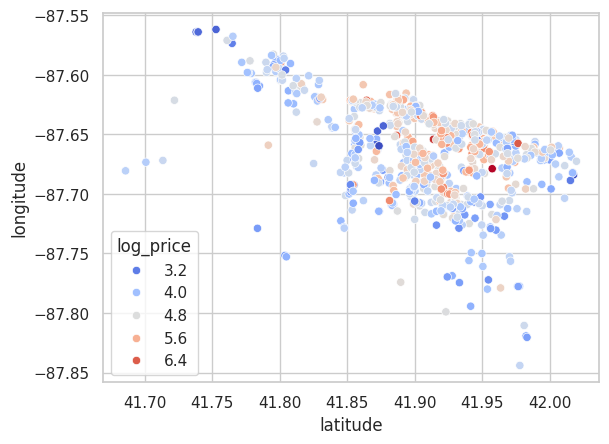

In [459]:
filtered_data = airbnb_train[(airbnb_train['latitude'] >41 ) & (airbnb_train['longitude'] < -80)]

sns.scatterplot(x='latitude', y='longitude', data=filtered_data, hue='log_price', palette='coolwarm')


<Axes: xlabel='latitude', ylabel='longitude'>

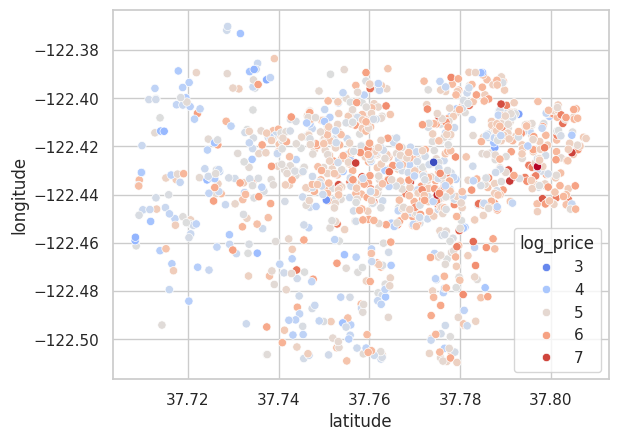

In [460]:
filtered_data = airbnb_train[(airbnb_train['latitude'] >37 ) & (airbnb_train['longitude'] < -120)]

sns.scatterplot(x='latitude', y='longitude', data=filtered_data, hue='log_price', palette='coolwarm')


Les trois exemples précédents nous permettent de remarquer qui'il ya en effet une augmentation des prix lorsque l'on s'approche des  centres villes ou encore des côtes du continent américains, même si ici ce ne sont pas des cartes .

Ainsi pour voir cela autrement, on propose de visualiser les airbnb et leur prix sur une carte réelle

In [461]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from IPython.display import display

# Charger les données
airbnb_train_crop = airbnb_train.head(500)

# Filtrer les colonnes pertinentes
map_data = airbnb_train_crop[['latitude', 'longitude', 'log_price']]

# Créer une carte centrée sur les coordonnées moyennes
m = folium.Map(location=[map_data['latitude'].mean(), map_data['longitude'].mean()], zoom_start=10)

# Utiliser un cluster de marqueurs pour mieux gérer les nombreux points
marker_cluster = MarkerCluster().add_to(m)

# Ajouter les points à la carte
for idx, row in map_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f'Log Price: {row["log_price"]}',
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(marker_cluster)

# Afficher la carte dans Jupyter Notebook
display(m)

In [462]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from IPython.display import display
import numpy as np

# Charger les données
airbnb_train_crop = airbnb_train.head(500)

# Filtrer les colonnes pertinentes
map_data = airbnb_train_crop[['latitude', 'longitude', 'log_price']]

# Calculer le prix réel à partir du log price
map_data['price'] = np.exp(map_data['log_price'])

# Fonction pour déterminer la couleur en fonction du prix
def get_color(price):
    if price < 100:
        return 'green'
    elif 100 <= price < 200:
        return 'orange'
    else:
        return 'red'

# Créer une carte centrée sur les coordonnées moyennes
m = folium.Map(location=[map_data['latitude'].mean(), map_data['longitude'].mean()], zoom_start=10)

# Utiliser un cluster de marqueurs pour mieux gérer les nombreux points
marker_cluster = MarkerCluster().add_to(m)

# Ajouter les points à la carte
for idx, row in map_data.iterrows():
    color = get_color(row['price'])
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f'Price: ${row["price"]:.2f}',
        color=color,
        fill=True,
        fill_color=color
    ).add_to(marker_cluster)

# Afficher la carte dans Jupyter Notebook
display(m)


<ipython-input-462-02c80fdc151c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_data['price'] = np.exp(map_data['log_price'])


Dans cette version, on peut filtrer les prix et verifier l'hypothèse précedente

In [463]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from IPython.display import display
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

# Charger les données

airbnb_train_crop = airbnb_train.head(500)

# Filtrer les colonnes pertinentes
map_data = airbnb_train_crop[['latitude', 'longitude', 'log_price']]

# Calculer le prix réel à partir du log price
map_data['price'] = np.exp(map_data['log_price'])

# Fonction pour déterminer la couleur en fonction du prix
def get_color(price):
    if price < 100:
        return 'green'
    elif 100 <= price < 200:
        return 'orange'
    else:
        return 'red'

# Fonction pour créer la carte avec un filtre de prix
def create_map(max_price):
    # Créer une carte centrée sur les coordonnées moyennes
    m = folium.Map(location=[map_data['latitude'].mean(), map_data['longitude'].mean()], zoom_start=10)

    # Utiliser un cluster de marqueurs pour mieux gérer les nombreux points
    marker_cluster = MarkerCluster().add_to(m)

    # Ajouter les points à la carte filtrés par le prix
    for idx, row in map_data.iterrows():
        if row['price'] <= max_price:
            color = get_color(row['price'])
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=5,
                popup=f'Price: ${row["price"]:.2f}',
                color=color,
                fill=True,
                fill_color=color
            ).add_to(marker_cluster)

    # Afficher la carte
    display(m)

# Création d'un curseur interactif
price_slider = widgets.FloatSlider(
    value=200,
    min=0,
    max=map_data['price'].max(),
    step=10,
    description='Max Price:',
    continuous_update=False
)

# Affichage du curseur et de la carte
interact(create_map, max_price=price_slider)


<ipython-input-463-d70221c528a1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_data['price'] = np.exp(map_data['log_price'])


interactive(children=(FloatSlider(value=200.0, continuous_update=False, description='Max Price:', max=1499.999…

<function __main__.create_map(max_price)>

Nous arrivons à l'étape du pré-processing et du features engineering, la premiere chose à faire est de transformer notre data frame de sorte à n'avoir que des valuers numériques qui peuvent être interpréter par un algo de prédiction, nous nous sommes donc basés sur la structure du code donné en exemple par le professeur, un mapping qui s'apparente beaucoup à ce que ferait un encoder comme One Hot par exemple mais ici on enumère manuellement les différentes catégories des différentes caractéristiques.

In [464]:
class CustomTransformation:
    def __init__(self):
      # Dictionnaires pour mapper les catégories textuelles en indices numériques
        self.fitted = False
        self.property2index = dict()
        self.room2index = dict()
        self.bed2index = dict()
        self.cancellation2index = dict()
        self.city2index = dict()
        self.bed_type2index = dict()
        self.host_has_profile_pic2index = {'f': 1, 't': 2}
        self.host_identity_verified2index = {'f': 1, 't': 2}
        self.instant_bookable2index = {'f': 1, 't': 2}
        self.cleaning_fee_index = {True: 1, False: 0}
        self.max_index = 0

    def fit_transform(self, dataset):
        self.fitted = True

       # Initialisation des mappings à partir des données uniques de chaque colonne catégorielle
        self.property2index = {prop: i for i, prop in enumerate(dataset["property_type"].dropna().unique())}
        self.room2index = {room: i for i, room in enumerate(dataset["room_type"].dropna().unique())}
        self.bed2index = {bed: i for i, bed in enumerate(dataset["bed_type"].dropna().unique())}
        self.cancellation2index = {cancel: i for i, cancel in enumerate(dataset["cancellation_policy"].dropna().unique())}
        self.city2index = {city: i for i, city in enumerate(dataset["city"].dropna().unique())}

        return self.transform(dataset)

    def transform(self, dataset):
       # Appliquer le mapping à chaque colonne catégorielle et remplacer les valeurs manquantes par 0
        dataset = dataset.copy()
        dataset = dataset.copy()
        dataset["property_type"] = dataset["property_type"].map(self.property2index).fillna(0)
        dataset["room_type"] = dataset["room_type"].map(self.room2index).fillna(0)
        dataset["bed_type"] = dataset["bed_type"].map(self.bed2index).fillna(0)
        dataset["cancellation_policy"] = dataset["cancellation_policy"].map(self.cancellation2index).fillna(0)
        dataset["city"] = dataset["city"].map(self.city2index).fillna(0)
        dataset["host_has_profile_pic"] = dataset["host_has_profile_pic"].map(self.host_has_profile_pic2index).fillna(0)
        dataset["host_identity_verified"] = dataset["host_identity_verified"].map(self.host_identity_verified2index).fillna(0)
        dataset["instant_bookable"] = dataset["instant_bookable"].map(self.instant_bookable2index).fillna(0)
        dataset['cleaning_fee'] = dataset['cleaning_fee'].map(self.cleaning_fee_index).fillna(0).astype(int)
        return dataset

    def get_mappings(self):
      # Renvoyer les mappings utilisés pour la conversion des données catégorielles
        return {
            "property_type": self.property2index,
            "room_type": self.room2index,
            "bed_type": self.bed2index,
            "cancellation_policy": self.cancellation2index,
            "city": self.city2index,
            "host_has_profile_pic": self.host_has_profile_pic2index,
            "host_identity_verified": self.host_identity_verified2index,
            "instant_bookable": self.instant_bookable2index,
            "cleaning_fee": self.cleaning_fee_index,
        }

        return dataset




In [465]:
class FeatureSelection:
    def __init__(self):
        pass

    def fit_transform(self, dataset, y=None):
        return self.transform(dataset)

    def transform(self, dataset):
        for col in dataset.columns:
            try:
                dataset[col] = pd.to_numeric(dataset[col], errors='ignore')
            except ValueError:
                # Pour les colonnes qui ne peuvent pas être converties en numérique, décider d'une stratégie appropriée
                pass
        return dataset

def count_amenities(data):
    # Nettoyer la colonne 'amenities' et compter le nombre d'aménités
    data['amenities_count'] = data['amenities'].str.replace("[{}]", "", regex=True) \
                                                .str.split(',').apply(lambda x: len(x) if isinstance(x, list) else 0)
    return data

# Appliquez cette transformation à votre DataFrame
airbnb_train_a = count_amenities(airbnb_train)


features_transformer = CustomTransformation()
airbnb_train_transformed = features_transformer.fit_transform(airbnb_train_a)

feature_selector = FeatureSelection()
mappings = features_transformer.get_mappings()
print(mappings)

# Application de la transformation
airbnb_train_transformed = features_transformer.fit_transform(airbnb_train)

# Application de la sélection (qui ne sélectionne rien mais convertit les types)
airbnb_train_custom = feature_selector.transform(airbnb_train_transformed)
airbnb_train_custom.head()

{'property_type': {'House': 0, 'Guest suite': 1, 'Apartment': 2, 'Condominium': 3, 'Timeshare': 4, 'Chalet': 5, 'Townhouse': 6, 'Guesthouse': 7, 'Bungalow': 8, 'Loft': 9, 'In-law': 10, 'Dorm': 11, 'Other': 12, 'Bed & Breakfast': 13, 'Camper/RV': 14, 'Boat': 15, 'Boutique hotel': 16, 'Villa': 17, 'Cabin': 18, 'Hostel': 19, 'Hut': 20, 'Serviced apartment': 21, 'Castle': 22, 'Vacation home': 23, 'Tent': 24, 'Cave': 25, 'Tipi': 26, 'Earth House': 27, 'Treehouse': 28}, 'room_type': {'Private room': 0, 'Entire home/apt': 1, 'Shared room': 2}, 'bed_type': {'Real Bed': 0, 'Pull-out Sofa': 1, 'Futon': 2, 'Airbed': 3, 'Couch': 4}, 'cancellation_policy': {'strict': 0, 'flexible': 1, 'moderate': 2, 'super_strict_30': 3, 'super_strict_60': 4}, 'city': {'NYC': 0, 'SF': 1, 'DC': 2, 'LA': 3, 'Chicago': 4, 'Boston': 5}, 'host_has_profile_pic': {'f': 1, 't': 2}, 'host_identity_verified': {'f': 1, 't': 2}, 'instant_bookable': {'f': 1, 't': 2}, 'cleaning_fee': {True: 1, False: 0}}


id  log_price  property_type  room_type  \
1  14483613    4.00733              0          0   
3  17954362    3.55535              0          0   
4   9969781    5.48064              0          1   
7  12112830    4.39445              1          1   
9     94477    5.52146              2          1   

                                           amenities  accommodates  bathrooms  \
1  {"Wireless Internet","Air conditioning",Kitche...             4    2.00000   
3  {TV,"Cable TV",Internet,"Wireless Internet","A...             1    1.00000   
4  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4    1.00000   
7  {TV,"Cable TV","Wireless Internet","Air condit...             3    1.00000   
9  {TV,"Cable TV",Internet,"Wireless Internet","A...             4    1.00000   

   bed_type  cancellation_policy  cleaning_fee  ...  \
1         0                    0             0  ...   
3         0                    1             1  ...   
4         0                    2             1  ...   
7         1                    2             0  ...   
9         0                    2             1  ...   

                                       name    neighbourhood  \
1       beautiful simple room beds mins nyc        Ridgewood   
3  manhattan view queens lovely single room        Sunnyside   
4             zen captured noe valley house       Noe Valley   
7              private suite free metrocard         Flushing   
9            fabulous uws bedroom apartment  Upper West Side   

  number_of_reviews  review_scores_rating  zipcode bedrooms    beds  \
1                38              86.00000    11385  1.00000 2.00000   
3                19              96.00000    11104  1.00000 1.00000   
4                15              96.00000    94131  2.00000 2.00000   
7               213              93.00000    11355  0.00000 2.00000   
9                77              96.00000    10024  2.00000 3.00000   

                                      amenities_list  \
1  [Wireless Internet, Air conditioning, Kitchen,...   
3  [TV, Cable TV, Internet, Wireless Internet, Ai...   
4  [TV, Cable TV, Internet, Wireless Internet, Ki...   
7  [TV, Cable TV, Wireless Internet, Air conditio...   
9  [TV, Cable TV, Internet, Wireless Internet, Ai...   

                                   description_clean  amenities_count  
1  private room rent six bedroom apt two bathroom...               25  
3  place close manhattan see top world trade cent...               30  
4  beautiful home dream destination whether plan ...               24  
7  looking affordable place stay nyc perfect room...               32  
9  lower near central park museum natural history...               18  

[5 rows x 31 columns]

Biensûr, on applique ce procédé au maximum d'attributs mais certains ne sont pas convertible, on pense notamment au titre et à la description par exemple.
On peut donc observer plus de distribution,comme ci dessous, aucun réel intêret mais il faut les afficher.

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'log_price'}>,
        <Axes: title={'center': 'property_type'}>,
        <Axes: title={'center': 'room_type'}>],
       [<Axes: title={'center': 'accommodates'}>,
        <Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'bed_type'}>,
        <Axes: title={'center': 'cancellation_policy'}>],
       [<Axes: title={'center': 'cleaning_fee'}>,
        <Axes: title={'center': 'city'}>,
        <Axes: title={'center': 'host_has_profile_pic'}>,
        <Axes: title={'center': 'host_identity_verified'}>],
       [<Axes: title={'center': 'instant_bookable'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'number_of_reviews'}>],
       [<Axes: title={'center': 'review_scores_rating'}>,
        <Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'beds'}>,
        <Axes: title={'center': 'amenities_count'}>]]

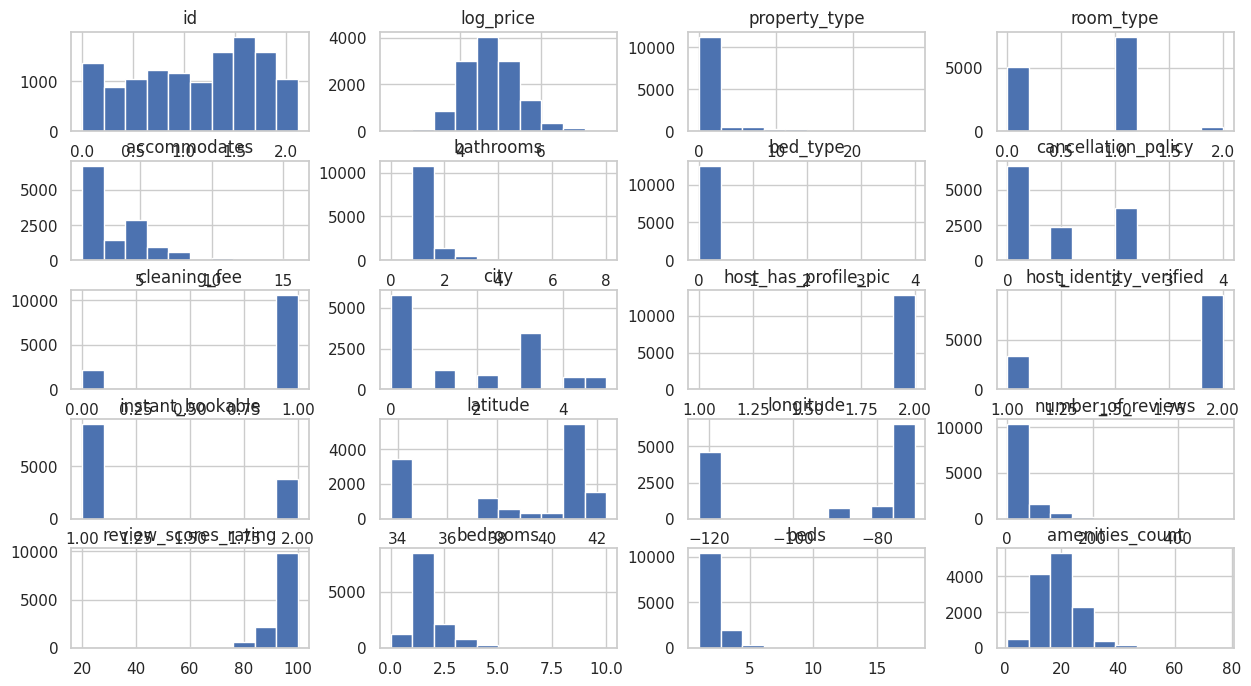

In [466]:
airbnb_train_custom.hist(figsize=(15,8))

Nous avons décidé d'introduire trois nouvelles colonnes dans le datatframe: amenitites_count, ration_lit_personnes et ratio_sbd_chambres, leurs noms décrivent très bien ce qu'ils représentent, ce sont des caractéristiques qui découlent de celle de base, et nous avons confirmer leur utilité dans la matrice de corrélation suivante.

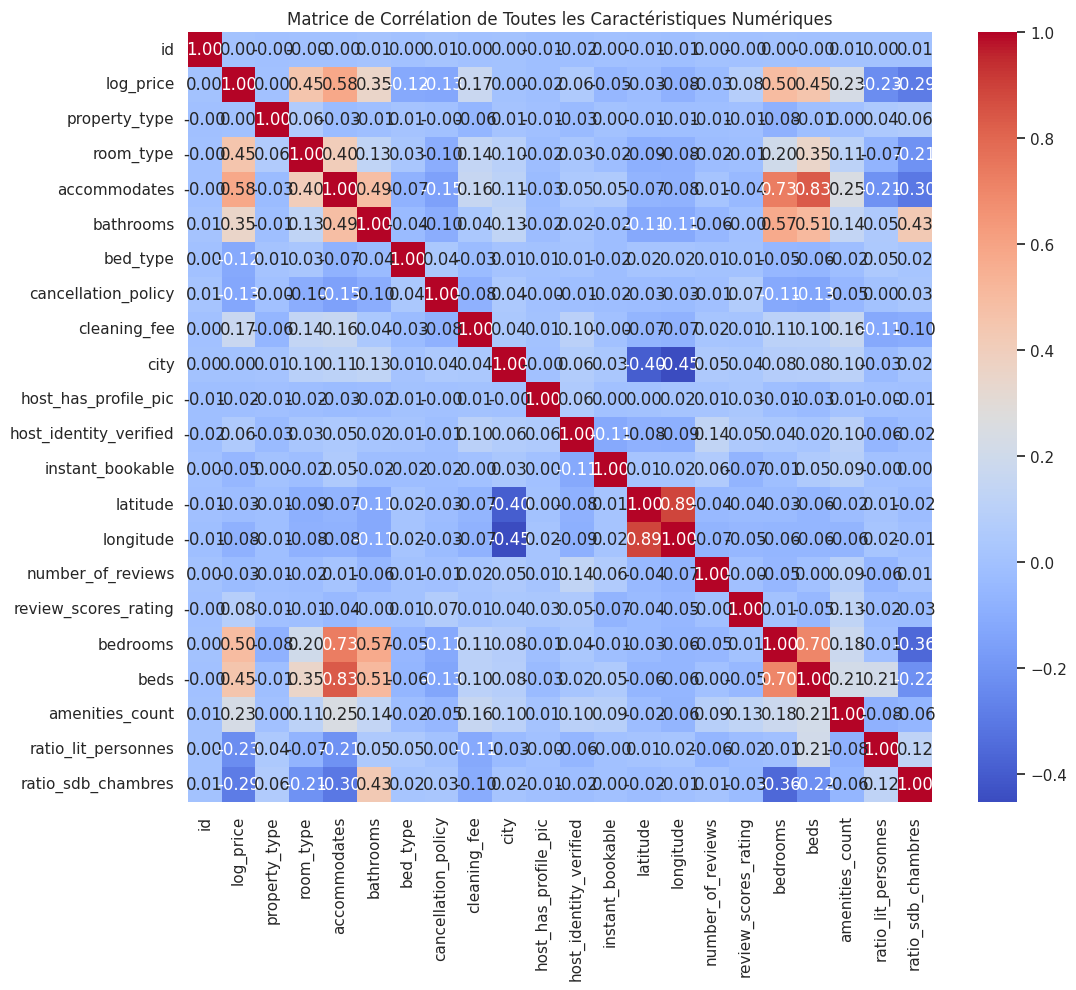

In [467]:



airbnb_train_custom['ratio_lit_personnes']=airbnb_train_custom['beds']/airbnb_train_custom['accommodates']

# Création de la colonne avec gestion des divisions par zéro
airbnb_train_custom['ratio_sdb_chambres'] = np.where(
    airbnb_train_custom['bedrooms'] != 0,
    airbnb_train_custom['bathrooms'] / airbnb_train_custom['bedrooms'],
    np.nan  # Ou une autre valeur appropriée comme 0 ou une moyenne conditionnelle
)
# Remplacer les NaN par une valeur, par exemple la médiane du ratio
median_ratio = airbnb_train_custom['ratio_sdb_chambres'].median()
airbnb_train_custom['ratio_sdb_chambres'].fillna(median_ratio, inplace=True)

numeric_data = airbnb_train_custom.select_dtypes(include=[np.number])

# Calculer la matrice de corrélation
corr_matrix = numeric_data.corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de Corrélation de Toutes les Caractéristiques Numériques')
plt.show()

La matrice de corrélation va nous permettre de déterminer quelles features conserver, ici on recherche ce qui est le plus corrélé avec le log_price et on voit que accommodates est le plus élevé avec 0.56
On trace donc le graphe des log_price en fonction des accommodates pour essayer de visualiser ce qu'il se passe

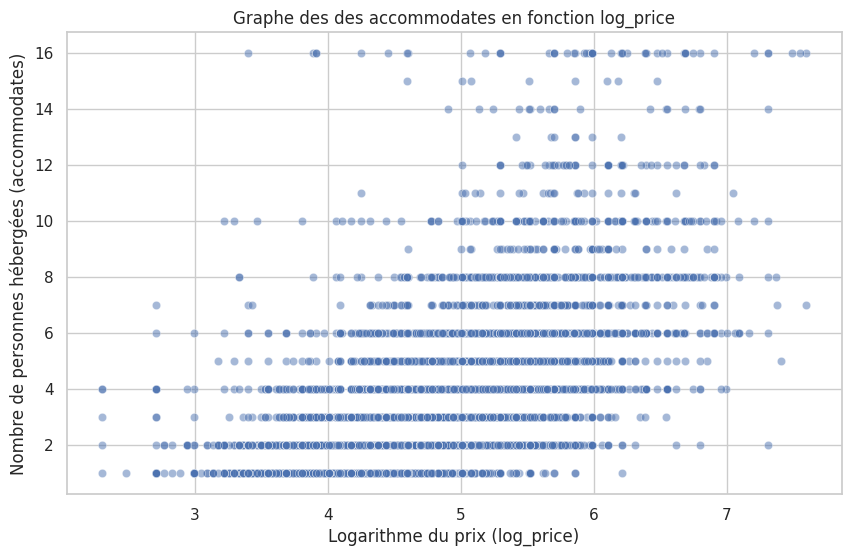

In [468]:


# On filtre les colonnes pertinentes
data = airbnb_train[['accommodates', 'log_price']]

# Tracer le graphe des log_price en fonction des accommodates
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_price', y='accommodates', data=data, alpha=0.5)
plt.title('Graphe des des accommodates en fonction log_price')
plt.ylabel('Nombre de personnes hébergées (accommodates)')
plt.xlabel('Logarithme du prix (log_price)')
plt.show()

#On remarque bien que plus de nombre de personnes logés augmente et plus le logarithme du prix augmente ce qui est bien cohérent avec la réalité.


On peut observer une relation de linéarité entre le log_price et accomodates, c'est ce que l'on recherche dans le cadre d'une prediction.

Dans la partie suivante, on va tenter d'appliquer la pca à notre jeu de donnée, le but serait de voir encore une fois voir les features qui contiendrait beaucoup d'information pour notre prediction

id                        False
log_price                 False
property_type             False
room_type                 False
accommodates              False
bathrooms                 False
bed_type                  False
cancellation_policy       False
cleaning_fee              False
city                      False
host_has_profile_pic      False
host_identity_verified    False
instant_bookable          False
latitude                  False
longitude                 False
number_of_reviews         False
review_scores_rating      False
bedrooms                  False
beds                      False
amenities_count           False
ratio_lit_personnes       False
ratio_sdb_chambres        False
dtype: bool
id                        False
log_price                 False
property_type             False
room_type                 False
accommodates              False
bathrooms                 False
bed_type                  False
cancellation_policy       False
cleaning_fee              Fa

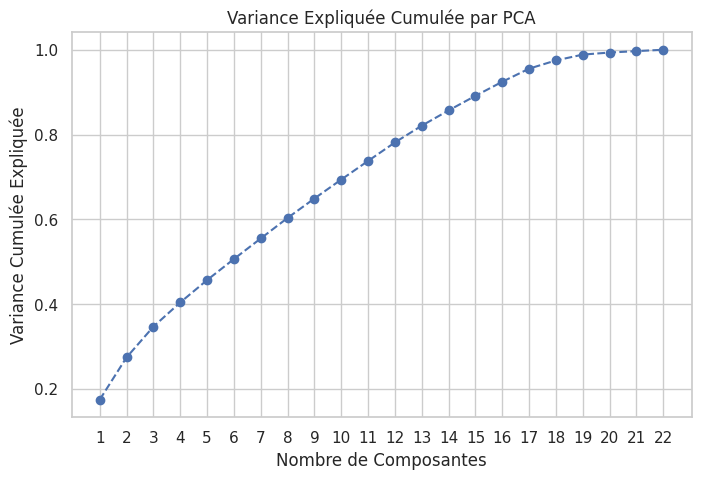

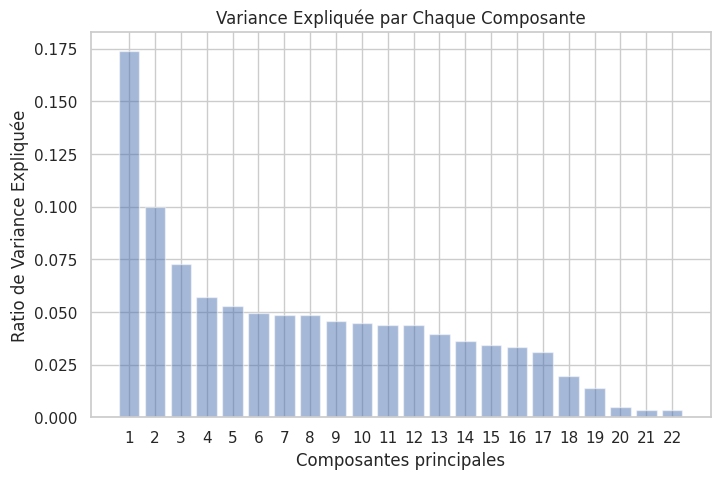

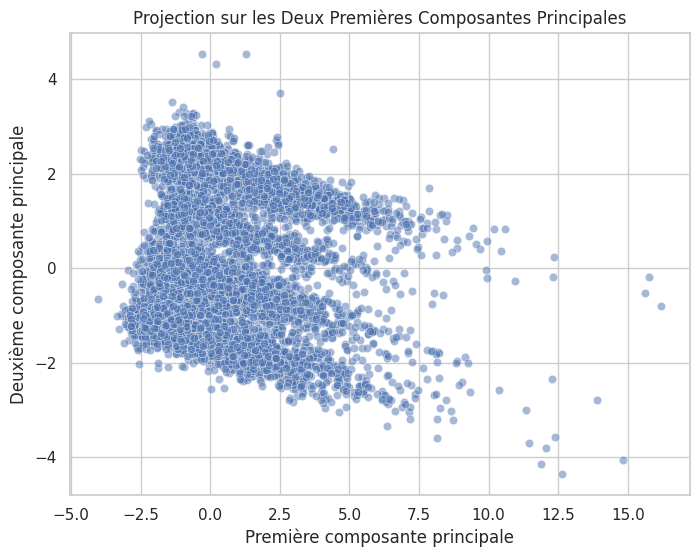

In [469]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Vérifier si des valeurs sont infinies ou NaN
print(numeric_data.isin([np.inf, -np.inf]).any())
print(numeric_data.isna().any())

# Remplacer les infinis par NaN, puis remplacer tous les NaN par la moyenne (ou une autre statistique) des colonnes
numeric_data.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_data.fillna(numeric_data.mean(), inplace=True)
# Supposons que 'numeric_data' est déjà votre DataFrame prétraité
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_data)

# Appliquer PCA
pca = PCA()
pca.fit(numeric_scaled)

# Pourcentage de variance expliquée par chaque composante
variance_ratio = pca.explained_variance_ratio_

# Tracer la variance cumulée
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variance_ratio) + 1), variance_ratio.cumsum(), marker='o', linestyle='--')
plt.title('Variance Expliquée Cumulée par PCA')
plt.xlabel('Nombre de Composantes')
plt.ylabel('Variance Cumulée Expliquée')
plt.xticks(range(1, len(variance_ratio) + 1))
plt.show()

# Tracer la variance expliquée par chaque composante
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.5, align='center', label='Variance individuelle expliquée')
plt.title('Variance Expliquée par Chaque Composante')
plt.xlabel('Composantes principales')
plt.ylabel('Ratio de Variance Expliquée')
plt.xticks(range(1, len(variance_ratio) + 1))
plt.show()
# Projection des données sur les deux premières composantes principales
pca_2d = PCA(n_components=2)
projected = pca_2d.fit_transform(numeric_scaled)

# Tracer les deux premières composantes principales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=projected[:, 0], y=projected[:, 1], alpha=0.5)
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')

plt.title('Projection sur les Deux Premières Composantes Principales')
plt.show()


In [470]:
# Composantes principales
components = pca.components_

# Afficher les variables les plus importantes pour la première composante principale
important_features_first_component = pd.Series(components[0], index=numeric_data.columns).sort_values(ascending=False)
print("Variables les plus importantes pour la première composante principale:")
print(important_features_first_component)

Variables les plus importantes pour la première composante principale:
accommodates              0.46154
beds                      0.42691
bedrooms                  0.41967
log_price                 0.37208
bathrooms                 0.30312
room_type                 0.26214
amenities_count           0.17914
cleaning_fee              0.12740
city                      0.10649
host_identity_verified    0.05002
review_scores_rating      0.01071
instant_bookable          0.00919
id                        0.00151
number_of_reviews        -0.00066
host_has_profile_pic     -0.01577
property_type            -0.02043
bed_type                 -0.05230
ratio_lit_personnes      -0.05751
cancellation_policy      -0.10246
latitude                 -0.10501
longitude                -0.11840
ratio_sdb_chambres       -0.15791
dtype: float64


On peut voir qu'il n'y a pas vraiment de features qui se démarque réellement en portant une proportion conséquente de variance, ainsi, grâce aux deux dernières analyses on peut conclure sans trop prendre de risque sur la suppression de certaines features.

Passons maintenant à la partie prediction.

On va commencer par appliquer une prediction avec un model SVM.

In [471]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Supposons que airbnb_train est déjà préchargé et prétraité
X = numeric_data.drop('log_price', axis=1)  # Toutes les autres caractéristiques
y = numeric_data['log_price']  # Variable cible

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
from sklearn.svm import SVR

# Création du modèle SVR
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Entraînement du modèle sur les données d'entraînement
svr.fit(X_train_scaled, y_train)
from sklearn.metrics import mean_squared_error, r2_score

# Prédiction sur les données de test
y_pred = svr.predict(X_test_scaled)

# Calcul de l'erreur quadratique moyenne et du score R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 0.18025183573945872
R^2 Score: 0.5858172405617383


Le R2 score peut être meilleur, cela s'explique en raison de la grande taille du jeu de données, le SVM est plus efficace sur une data de petite taille.

On essaye donc d'appliquer l'algo de l'arbre de décision, plus adapté à notre data.

In [472]:
from sklearn.tree import DecisionTreeRegressor

# Création du modèle de régression par arbre de décision
tree_regressor = DecisionTreeRegressor(random_state=42)

# Entraînement du modèle sur les données d'entraînement
tree_regressor.fit(X_train, y_train)


# Prédiction sur les données de test
y_pred = tree_regressor.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")



Mean Squared Error: 0.23613363854144853
R^2 Score: 0.4574120057858341


Pas de chance ici le score n'est pas satisfaisant, on essaye avec le model de random forest qui va prendre plus de ressource mais devrait optimiser notre prediction.

Mean Squared Error: 0.12691234700124307
R^2 Score: 0.7083807447945223


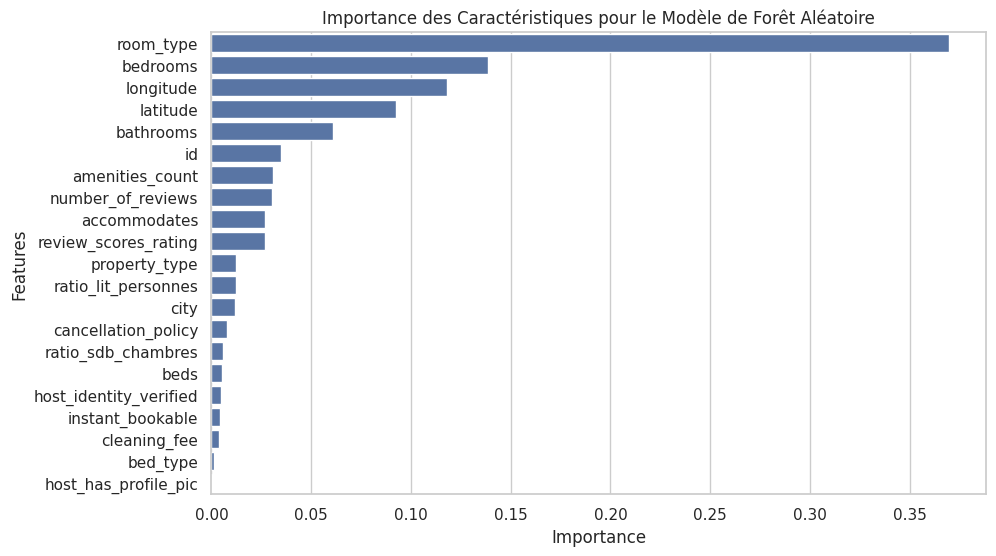

In [473]:
from sklearn.ensemble import RandomForestRegressor

numeric_data = airbnb_train_custom.select_dtypes(include=[np.number])


X = numeric_data.drop('log_price', axis=1)  # Toutes les autres caractéristiques
y = numeric_data['log_price']  # Variable cible
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Création du modèle de régression par forêt aléatoire
forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraînement du modèle sur les données d'entraînement
forest_regressor.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = forest_regressor.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

feature_importances = forest_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Visualisation des importances des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=importance_df)
plt.title('Importance des Caractéristiques pour le Modèle de Forêt Aléatoire')
plt.show()

#forest_pred()

Ca y est,cette prediction sur nos données d'entrainement sont convainquantes, on peut essayer d'améliorer le model en supprimant les features les moins pris encompte par l'algo, des features que nous savions déjà moins importantes à conserver grâce à la matrice de corrélation mais également la PCA:

In [474]:
#On supprime les colonnes du tableau qui nous selmblent impertinentes
columns_to_drop = ['id', 'host_has_profile_pic', 'instant_bookable', 'host_identity_verified', 'cancellation_policy']
#columns_to_drop
numeric_data = numeric_data.drop(columns = columns_to_drop)
numeric_data.head()

log_price  property_type  room_type  accommodates  bathrooms  bed_type  \
1    4.00733              0          0             4    2.00000         0   
3    3.55535              0          0             1    1.00000         0   
4    5.48064              0          1             4    1.00000         0   
7    4.39445              1          1             3    1.00000         1   
9    5.52146              2          1             4    1.00000         0   

   cleaning_fee  city  latitude  longitude  number_of_reviews  \
1             0     0  40.70547  -73.90944                 38   
3             1     0  40.73600  -73.92425                 19   
4             1     1  37.74490 -122.43067                 15   
7             0     0  40.75250  -73.81126                213   
9             1     0  40.78334  -73.97578                 77   

   review_scores_rating  bedrooms    beds  amenities_count  \
1              86.00000   1.00000 2.00000               25   
3              96.00000   1.00000 1.00000               30   
4              96.00000   2.00000 2.00000               24   
7              93.00000   0.00000 2.00000               32   
9              96.00000   2.00000 3.00000               18   

   ratio_lit_personnes  ratio_sdb_chambres  
1              0.50000             2.00000  
3              1.00000             1.00000  
4              0.50000             0.50000  
7              0.66667             1.00000  
9              0.75000             0.50000

Mean Squared Error: 0.12592512898158353
R^2 Score: 0.7106491748600046


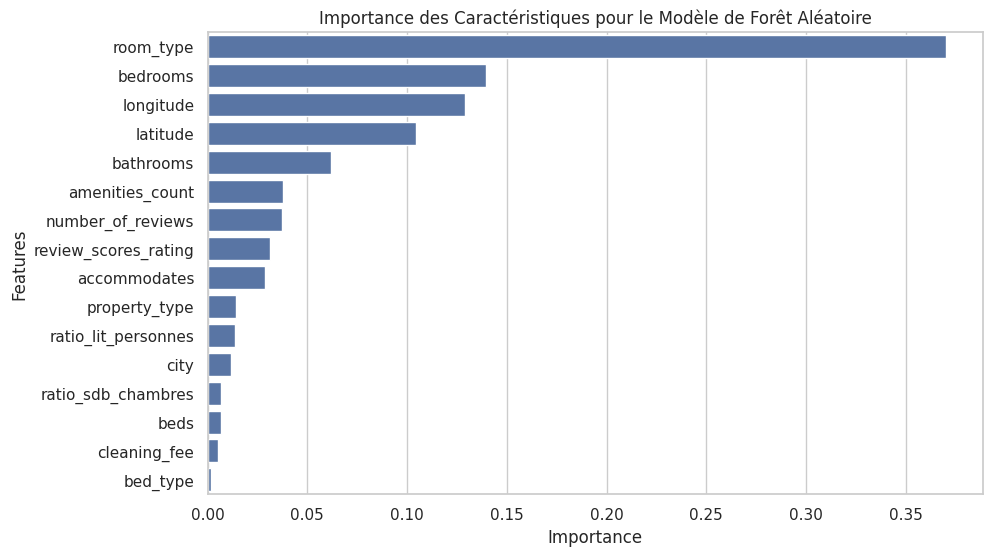

In [475]:
#on réexcute la fonction forest_pred() pour voir si cela change grand chose ou pas
#forest_pred()

X = numeric_data.drop('log_price', axis=1)  # Toutes les autres caractéristiques
y = numeric_data['log_price']  # Variable cible
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Création du modèle de régression par forêt aléatoire
forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraînement du modèle sur les données d'entraînement
forest_regressor.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = forest_regressor.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

feature_importances = forest_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Visualisation des importances des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=importance_df)
plt.title('Importance des Caractéristiques pour le Modèle de Forêt Aléatoire')
plt.show()


Le model s'améliore. Essayons en enlevant la colonne bed type:

In [476]:
columns_to_drop = ['bed_type']
numeric_data = numeric_data.drop(columns = columns_to_drop)
numeric_data.head()

log_price  property_type  room_type  accommodates  bathrooms  cleaning_fee  \
1    4.00733              0          0             4    2.00000             0   
3    3.55535              0          0             1    1.00000             1   
4    5.48064              0          1             4    1.00000             1   
7    4.39445              1          1             3    1.00000             0   
9    5.52146              2          1             4    1.00000             1   

   city  latitude  longitude  number_of_reviews  review_scores_rating  \
1     0  40.70547  -73.90944                 38              86.00000   
3     0  40.73600  -73.92425                 19              96.00000   
4     1  37.74490 -122.43067                 15              96.00000   
7     0  40.75250  -73.81126                213              93.00000   
9     0  40.78334  -73.97578                 77              96.00000   

   bedrooms    beds  amenities_count  ratio_lit_personnes  ratio_sdb_chambres  
1   1.00000 2.00000               25              0.50000             2.00000  
3   1.00000 1.00000               30              1.00000             1.00000  
4   2.00000 2.00000               24              0.50000             0.50000  
7   0.00000 2.00000               32              0.66667             1.00000  
9   2.00000 3.00000               18              0.75000             0.50000

Mean Squared Error: 0.12567324000847513
R^2 Score: 0.7112279654699649


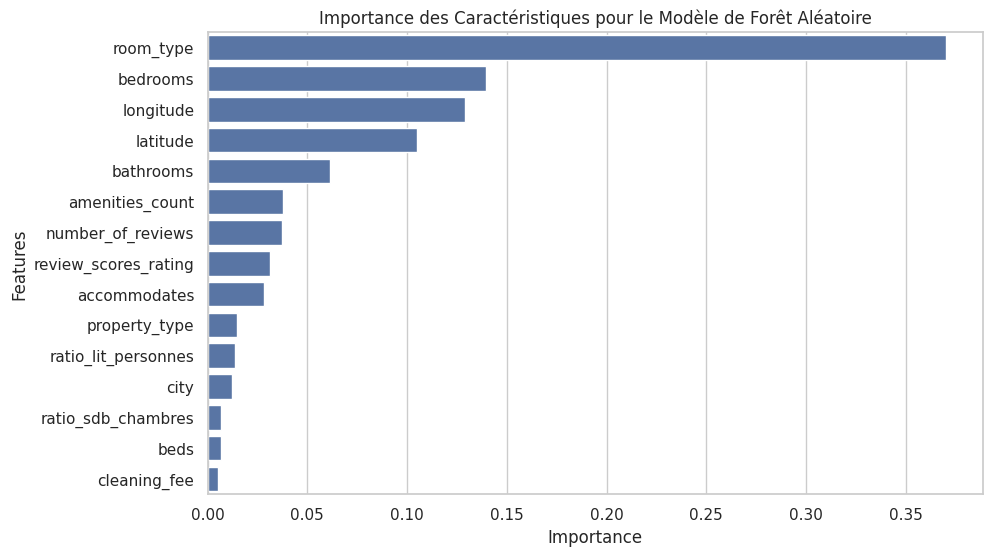

In [477]:


X = numeric_data.drop('log_price', axis=1)  # Toutes les autres caractéristiques
y = numeric_data['log_price']  # Variable cible
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Création du modèle de régression par forêt aléatoire
forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraînement du modèle sur les données d'entraînement
forest_regressor.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = forest_regressor.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

feature_importances = forest_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Visualisation des importances des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=importance_df)
plt.title('Importance des Caractéristiques pour le Modèle de Forêt Aléatoire')
plt.show()

#forest_pred()

Nous allons conserver ce model qui est très satisfaisant, Voici l'ecart entre nos predictions et les log_price:

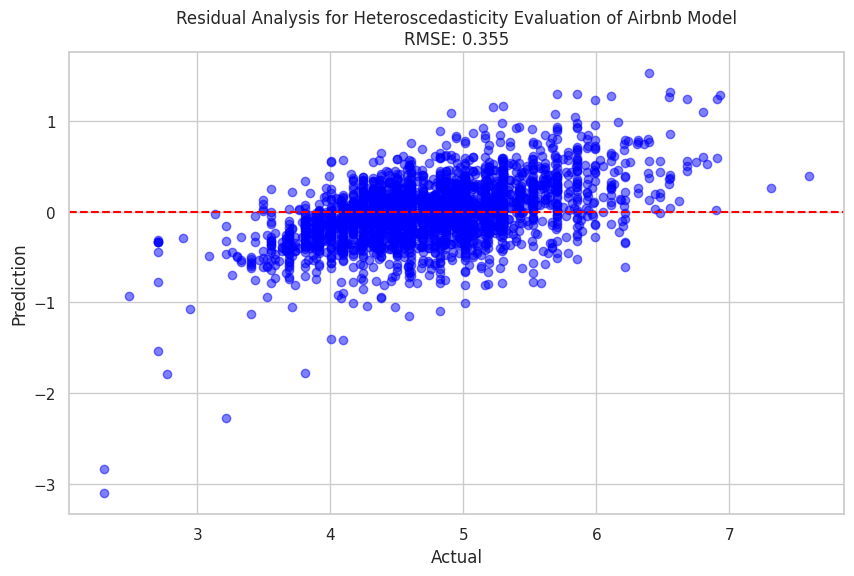

In [478]:
# Calcul des résidus
residuals = y_test - y_pred

# Calcul du RMSE
rmse = np.sqrt(np.mean(residuals**2))

# Création du graphique de résidus
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Analysis for Heteroscedasticity Evaluation of Airbnb Model\nRMSE: {:.3f}'.format(rmse))
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

On applique toute les modifications au fichier test.

In [479]:

airbnb_test = count_amenities(airbnb_test)
print(len(airbnb_test))

features_transformer = CustomTransformation()
airbnb_test = features_transformer.fit_transform(airbnb_test)

airbnb_test['ratio_lit_personnes']=airbnb_test['beds']/airbnb_test['accommodates']

airbnb_test = feature_selector.transform(airbnb_test)
airbnb_test['ratio_sdb_chambres'] = np.where(
    airbnb_test['bedrooms'] != 0,
    airbnb_test['bathrooms'] / airbnb_test['bedrooms'],
    np.nan  # Ou une autre valeur appropriée comme 0 ou une moyenne conditionnelle
)
median_ratio = airbnb_test['ratio_sdb_chambres'].median()
airbnb_test['ratio_sdb_chambres'].fillna(median_ratio, inplace=True)



numeric_data_test = airbnb_test.select_dtypes(include=[np.number])

# Remplacer les infinis par NaN, puis remplacer tous les NaN par la moyenne (ou une autre statistique) des colonnes
numeric_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_data_test.fillna(numeric_data.mean(), inplace=True)


#On supprime les colonnes du tableau qui nous selmblent impertinentes
columns_to_drop = ['Unnamed: 0', 'host_has_profile_pic', 'instant_bookable', 'host_identity_verified', 'cancellation_policy']
#columns_to_drop
numeric_data_test = numeric_data_test.drop(columns = columns_to_drop)


columns_to_drop = ['bed_type']
numeric_data_test = numeric_data_test.drop(columns = columns_to_drop)

numeric_data_test.head()

51877


property_type  room_type  accommodates  bathrooms  cleaning_fee  city  \
0              0          0             3    1.00000             1     0   
1              0          0             7    1.00000             1     0   
2              0          0             5    1.00000             1     0   
3              1          0             4    1.00000             1     1   
4              0          0             2    1.00000             1     2   

   latitude  longitude  number_of_reviews  review_scores_rating  bedrooms  \
0  40.69652  -73.99162                  2             100.00000   1.00000   
1  40.76612  -73.98904                  6              93.00000   3.00000   
2  40.80811  -73.94376                 10              92.00000   1.00000   
3  37.77200 -122.43162                  0              94.20193   2.00000   
4  38.92563  -77.03460                  4              40.00000   0.00000   

     beds  amenities_count  ratio_lit_personnes  ratio_sdb_chambres  
0 1.00000                9              0.33333             1.00000  
1 3.00000               15              0.42857             0.33333  
2 3.00000               19              0.60000             1.00000  
3 2.00000               15              0.50000             0.50000  
4 1.00000               12              0.50000             1.00000

In [480]:

# Prédiction sur les données de test
y_test_pred = forest_regressor.predict(numeric_data_test)

# Affichage des prédictions
print(y_test_pred)
len(y_test_pred)

[4.6777286  5.23607504 4.47865601 ... 4.59827645 4.74899633 4.85463759]


51877

In [481]:
prediction = pd.read_csv("prediction_example.csv")
prediction["logpred"] = y_test_pred

prediction.to_csv("MaPredictionFinale.csv", index=False) # index=False pour éviter d’ajouter l’index interne à pandas
# Voilà !

In [482]:
def estConforme(monFichier_csv):
    votre_prediction = pd.read_csv(monFichier_csv)

    fichier_exemple = pd.read_csv("prediction_example.csv")

    assert votre_prediction.columns[1] == fichier_exemple.columns[1], f"Attention, votre colonne de prédiction doit s'appeler {fichier_exemple.columns[1]}, elle s'appelle '{votre_prediction.columns[1]}'"
    assert len(votre_prediction) == len(fichier_exemple), f"Attention, vous devriez avoir {len(fichier_exemple)} prédiction dans votre fichier, il en contient '{len(votre_prediction)}'"

    assert np.all(votre_prediction.iloc[:,0] == fichier_exemple.iloc[:, 0])

    print("Fichier conforme!")

estConforme("MaPredictionFinale.csv")

Fichier conforme!
